In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as consts

from scipy import signal, stats, fft, ndimage
from tqdm import tqdm

# Implementation - Modelling Intensity Fluctuations of Rayleigh Backscattered Coherent Light in Single-Mode Fibers

Here, we want to implement this equation:
$$ E_b (z = 0, k) = E_0 C A \sum_{i = 1}^N E_i $$
where
$$ E_i = \exp(j2\phi_{i-1}) \int_{d/2}^{-d/2} \exp(-\alpha(l + z_i) - j 2 \bar{n}_i k l)dl$$
and 
$$ \phi = \phi_{i - 1} + \bar{n}_i kd.$$
- $\alpha$, `α`: power attenuation coefﬁcient of the ﬁber
- $E_0$, `E_0`: launched ﬁeld
- $C$, `C`: average backscattering ﬁeld coefﬁcient
- $A$, `A`: mode ﬁeld effective area

In [3]:
α = 10 **(0.2 / 10) * 1e-3                  # db / km
E_0 = 1e-3 / (np.pi * (8 / 1e3) ** 2)      # V / m (equivalent of 1 mW with a fiber of 8 mm diameter)
C = 70                                      # um^2
A = 2.13                                    # um^-2

We model the variation of refractive index in the fiber as
$$ \bar{n}_i = 1.44 + \xi_i 10^{-7}. $$
in segments of $d = 1$ cm, where $\xi_i$ is a uniformly distributed random variable in $[0, 1]$. On pose une fibre de 1 km and $\phi_0 = 0$.

In [4]:
FIBER_LENGTH = 1e3                 # 10 km
AVERAGE_SEGMENT_SIZE = 1e-2         # 1 cm

number_of_segments = int(FIBER_LENGTH / AVERAGE_SEGMENT_SIZE)

n_bar = 1.44 + 1e-7 * np.random.rand(number_of_segments)
delta_d = np.random.rand(number_of_segments) / 10 - 0.05
d = (np.ones_like(n_bar) + delta_d) * 1e-2  # segments of 1 cm
z = np.cumsum(d)
k = 2 * np.pi / 1.55e-6

phi = np.zeros(number_of_segments + 1)
phi[1:] = np.cumsum(n_bar) * k * d

We can resolve analyticaly the integral to find
$$
\int_{-\mathrm{d} / 2}^{\mathrm{d} / 2} \exp \left(-\alpha\left(l+z_i\right)-j 2 \bar{n}_i k l\right) d l = \frac{2 \exp(-\alpha z_i) \sinh(\frac{d}{2} (\alpha + j 2 \bar{n}_i k))}{\alpha + j 2 \bar{n}_i k}
$$

In [ ]:
'''
import sympy as sp

alpha, d, z_i, n_bar_i, k = sp.symbols("alpha d, z_i, n_bar_i, k", constant=True, real=True)
l = sp.symbols("l")

integrand = sp.exp(- alpha * (l + z_i) - sp.I * 2 * n_bar_i * k * l)
sp.integrate(integrand, (l , -d / 2, d / 2))
'''

'\nimport sympy as sp\n\nalpha, d, z_i, n_bar_i, k = sp.symbols("alpha d, z_i, n_bar_i, k", constant=True, real=True)\nl = sp.symbols("l")\n\nintegrand = sp.exp(- alpha * (l + z_i) - sp.I * 2 * n_bar_i * k * l)\nsp.integrate(integrand, (l , -d / 2, d / 2))\n'

In [5]:
def compute_electric_field(phi, d, α, z, n_bar, k):
    return np.exp(1j * 2 * phi[:-1]) * 2 * np.exp(-α * z) * np.sinh(d / 2 * (α + 1j * 2 * n_bar * k)) / (α + 1j * 2 * n_bar * k)

E_i = compute_electric_field(phi, d, α, z, n_bar, k)

We then simulate the impact of pulse and detection.

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [7]:
pulse_width_points = 40         # points

E_ip = np.convolve(E_i, np.ones(pulse_width_points))    
E_b = E_0 * C * A * E_ip
I_b = np.abs(E_b) ** 2 / (1 / (consts.epsilon_0 * consts.c))

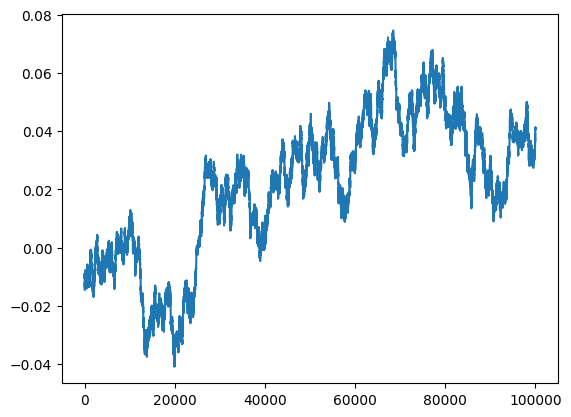

In [11]:
plt.plot(np.arange(0, FIBER_LENGTH, 1e-2) - z)

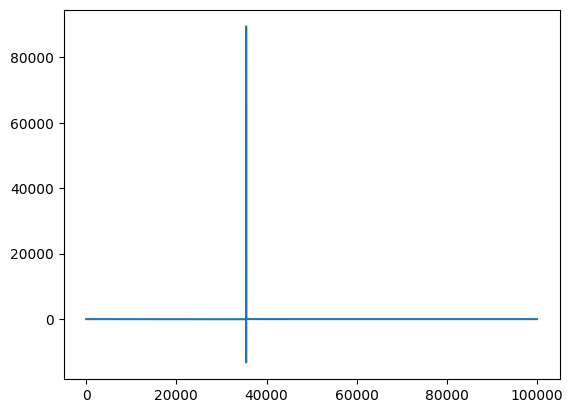

In [13]:
plt.plot(fft.fft(np.exp(-1j * 2 * 1.44 * k * np.arange(0, FIBER_LENGTH, 1e-2))))

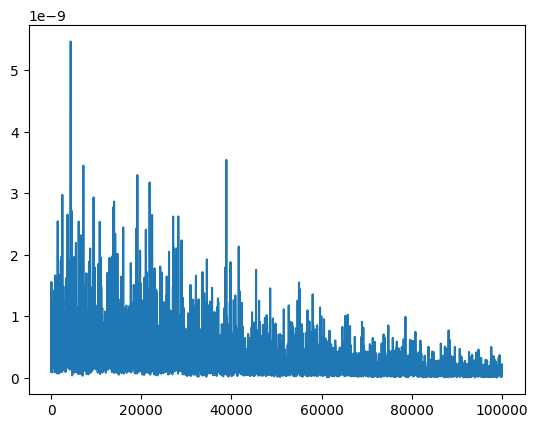

In [7]:
plt.plot(moving_average(I_b, n=25))
plt.show()
#plt.xlim(0 ,1000)

In [24]:
M = 49
central_frequency = 194e12      # Hz
frequency_bandwidth = 1e6      # Hz  should be 20
frequency_step = 250            # Hz
frequencies = np.arange(central_frequency - frequency_bandwidth / 2, central_frequency + frequency_bandwidth / 2, frequency_step)

wavelengths = consts.c / frequencies
ks = 2 * np.pi / wavelengths

phi = np.zeros((number_of_segments + 1, ks.size))
phi[1:] += np.cumsum(n_bar, axis=0)[:,None]
phi[1:,:] = phi[1:,:] * ks[None,:] * d[:,None]

out = compute_electric_field(phi[:,None], d[:,None], α, z[:,None], n_bar[:,None], ks[None,:])

Model linewdith and apply to each electric field

In [62]:
linewidth = 3e3         # Hz
lineshape = stats.norm.pdf(frequencies, central_frequency, linewidth)
lineshape /= lineshape.sum()

E_i = out * lineshape[None,:]

We apply the pulse width

In [69]:
T = 1e-2 * 1.44 / consts.c      # s / segment
pulse_width = 100e-9            # s
pulse_width_points = int(pulse_width / T)

2081

In [71]:
E_ip = ndimage.convolve1d(E_i, np.ones(pulse_width_points), axis = 0)    
E_b = E_0 * C * A * E_ip

: 

We convert the fields to itensity and sum over each frequency.

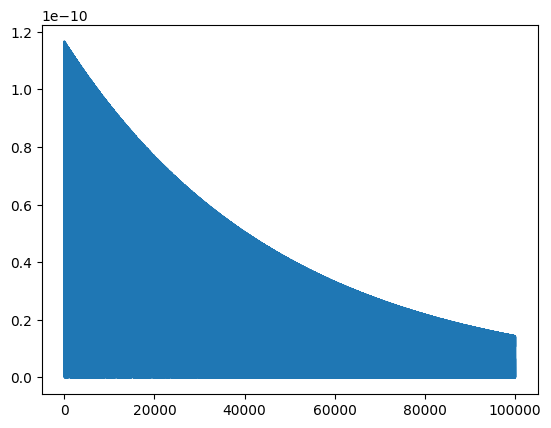

In [63]:
I_b = ((np.abs(E_i) ** 2)).sum(axis=1)

plt.plot()
plt.show()

# Implementation - Analysis of distributed optical fibre acoustic sensors through numerical modelling

In [ ]:
# Fixed parameters 

detector_bandwidth = 300e6      # Hz
sampling_rate = 5e9             # Sa / s
scattering_interval = 20e-3     # m
frequency_step = 2.5e6          # Hz
wavelength_step = 0.02e-12      # m
linewidth = 10e-12              # m
probe_length = 50e-2            # m

First, let's construct the optical fiber, knowing that
$$ z_m = m d + \delta z_m = d(m + \xi_m)  $$
where $\xi_m$ is a uniformly distributed random variable in $[0, 1]$, $z_m$ is the location of the $m$-th scattering element and $d$ the length of the scattering interval. A limit on $d$ can be imposed:
$$ d \lll \frac{c T_P}{2n_g} = \Delta z$$
such that the scattering zone is much smaller than the pulse duration. The variance on the amplitude of the scatteres is given by 
$$ \langle{} a^2 \rangle{} = P_P \alpha_R B d \frac{4 \pi}{c n_g S_{eff}}. $$


Unsure if I should use this:
$$ \langle{} a^2 \rangle{} = \frac{d}{\Delta z}$$
where $\Delta z$ is the pulse width.

In [ ]:
fiber_length = 1e3       # m
number_of_scatterers = int(fiber_length / scattering_interval)

locations = scattering_interval * (np.arange(number_of_scatterers) + np.random.rand(number_of_scatterers))

Here, we ignore dispersion because the linewdith is very narrow. We also ignore the polarisation of the incident and received optical pulse.

In [ ]:
# Construct sech-squared probe pulse

probe_duration = 100e-12
linewidth = 2 * 0.315 / probe_duration         # 2 times Fourier limit
refractive_index = 1.5
coherence_length = 

N =  refractive_index * linewidth * L_C / consts.c

SyntaxError: invalid syntax (2345674326.py, line 6)